In [1]:
%matplotlib inline

import os 
import sys 
import time
import hashlib

from datetime  import datetime 

import numpy as np  # learn 
import pandas as pd # learn
from pandas import *
from numpy import *

from scipy import stats # look at scipy
from scipy import linalg
from scipy import *
 
import matplotlib as mplt # learn matplolib 
from matplotlib import cm
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

from mpl_toolkits.mplot3d import Axes3D
from mpl_toolkits.mplot3d import proj3d

# import seaborn as sns 
# sns.set_style("whitegrid")
# sns.set(rc={"figure.figsize": (14, 6)})

import IPython
from IPython.display import display


import matplotlib
from matplotlib.ticker import FuncFormatter
import matplotlib.pyplot as plt
 
# import sklearn as sk
import itertools

# from pyspark import SparkContext, SparkConf
# from pyspark.sql import SQLContext
# from pyspark.sql.types import *
# from pyspark.mllib.regression import LabeledPoint

from keras.models import Sequential 
from keras.layers.core import Dense, Activation, TimeDistributedDense, Dropout
from keras.layers.recurrent import LSTM
from keras.optimizers import *
# RMSprop, Adadelta
from keras.regularizers import l2, activity_l2

import scipy.stats as st


from random import random


# http://sebastianruder.com/optimizing-gradient-descent/
# https://leemendelowitz.github.io/blog/how-does-python-find-packages.html

Using Theano backend.


In [2]:
# block1: Training dataset

# load and extract yahoo data
# choose the data in files real_11-20, which contains a time series (data point 3000 - 10000) with mediate 
#  outlier magnitude 

#  this dataset will be used for realtime training RNN 
# 6,13,15,11,22,29,56,31,39,57,43,65, 55,62


# 13 23 29 44
# final chosen one: 2,3

figsize= ( 10,5)

def value_drift_observe( ts, file_name ):
    valDrift =  [ ts[i+1]-ts[i] for i in range(len(ts)-1) ]
    
    fig = plt.figure()
    figure_size= figsize
    fig.set_size_inches( figure_size )

    axes = plt.gca()
#     axes.set_xlim([1, len(ts)+10])
#     axes.set_ylim([-2000,maxval+2000])

    plt.plot( valDrift, label='value drifts: x_t - t_(t-1)' )
# plt.plot( list( clean_tdf['value']), color='g' )
# plt.scatter( list(outlier_tdf['timestamp']),list(outlier_tdf['value']), color='red',\
#              label='Outliers')
# plt.xticks([1,2,3,4,5], ['5','10','15','20','25'] )
# plt.ticklabel_format(style='sci', axis='y', scilimits=(0,0))


# axes.xaxis.set_ticks( ['5m', '10m', '15m','20m'] ) 
# axes.xaxis.set_major_locator(MaxNLocator(integer=True))
    plt.title('Value drift in ' + file_name )
    plt.ylabel('Value')
    plt.xlabel('Time')
# plt.legend( loc='upper left',fontsize=12 )
    plt.legend() 
    
def yahoo_load_data( fileNo,  dta_folder):
    
    is_clean=0
    
    tmpdf= pd.read_csv( dta_folder + str(fileNo) + ".csv")
    tmpdf.drop('timestamp', axis=1, inplace=True)
    tmp_col=  range( 1, tmpdf.shape[0]+1 ) 
    tmpdf.insert(0, 'timestamp', tmp_col)
    tdf= tmpdf
        
    maxval= max(tdf['value'])
    minval= min(tdf['value'])

    outlier_tdf= tdf[ tdf['is_anomaly'] ==1  ]
    clean_tdf =  tdf[ tdf['is_anomaly'] ==0  ]

    if is_clean==1:
        ts= clean_tdf['value']
    else:
        ts= tdf['value']
    
    ts_flag= list(tdf['is_anomaly'])

#     print "size of clean data:",clean_tdf.shape
#     print "size of noisy data:", ts.shape, len(ts_flag)
#     print outlier_tdf
    
    # .............plot.................

    matplotlib.rcParams.update({'font.size': 15})
    figure_size= figsize
    legend_font= 8.5
    fig = plt.figure()
    fig.set_size_inches( figure_size )

    axes = plt.gca()
    axes.set_xlim([1, tdf.shape[0]+10])
    # axes.set_ylim([-2000,maxval+2000])

    plt.plot( list( tdf['value']), label='Normal data' )
    # plt.plot( list( clean_tdf['value']), color='g' )
    plt.scatter( list(outlier_tdf['timestamp']),list(outlier_tdf['value']), color='red',\
             label='Outliers',s=50)
#                 marker='+')
    # plt.xticks([1,2,3,4,5], ['5','10','15','20','25'] )
    # plt.ticklabel_format(style='sci', axis='y', scilimits=(0,0))


    # axes.xaxis.set_ticks( ['5m', '10m', '15m','20m'] ) 
    # axes.xaxis.set_major_locator(MaxNLocator(integer=True))
    plt.title('Yahoo Real Data ('+'files: real_' + str(fileNo) +')')
    plt.ylabel('Value')
    plt.xlabel('Time')
    # plt.legend( loc='upper left',fontsize=12 )
    plt.legend(loc='upper left')
    #     bbox_to_anchor=(0., 1.0, 1., .10),
    #            loc=0,
    #            ncol=5, mode="expand", borderaxespad=0., fontsize= legend_font , numpoints=1 )

    value_drift_observe( list(tdf['value']), 'real_'+str(fileNo) )  
    
    #     fig.savefig('example_ts.pdf', format='pdf', bbox_inches='tight')
    
    
    return ts, ts_flag
    

# def activity_load_data_plot( fileNo,  dta_folder):



    
# ax.annotate('local max', xy=(3, 1),  xycoords='data',
#             xytext=(0.8, 0.95), textcoords='axes fraction',
#             arrowprops=dict(facecolor='black', shrink=0.05),
#             horizontalalignment='right', verticalalignment='top',
#             )

def plot_outlier( ts_t, ts_val, out_t, out_val, dataset_name):
    
    matplotlib.rcParams.update({'font.size': 15})
    figure_size= figsize
    legend_font= 8.5
    fig = plt.figure()
    fig.set_size_inches( figure_size )

    axes = plt.gca()
#     axes.set_xlim([1, tdf.shape[0]+10])
    # axes.set_ylim([-2000,maxval+2000])

    plt.plot( ts_t, ts_val ,label='Normal data' )
    # plt.plot( list( clean_tdf['value']), color='g' )
    plt.scatter( out_t ,out_val, color='red',label='Outliers')
    # plt.xticks([1,2,3,4,5], ['5','10','15','20','25'] )
    # plt.ticklabel_format(style='sci', axis='y', scilimits=(0,0))

    # axes.xaxis.set_ticks( ['5m', '10m', '15m','20m'] ) 
    # axes.xaxis.set_major_locator(MaxNLocator(integer=True))
    plt.title(dataset_name)
    plt.ylabel('Value')
    plt.xlabel('Time')
    # plt.legend( loc='upper left',fontsize=12 )
    plt.legend(loc='upper left')
    #     bbox_to_anchor=(0., 1.0, 1., .10),
    #            loc=0,
    #            ncol=5, mode="expand", borderaxespad=0., fontsize= legend_font , numpoints=1 )

    value_drift_observe( ts_val , dataset_name )  
    
    #     fig.savefig('example_ts.pdf', format='pdf', bbox_inches='tight')
    
def plot_outlier_cp( ts_t, ts_val, out_t, out_val, cp_t,cp_val, dataset_name):
    
    matplotlib.rcParams.update({'font.size': 15})
    figure_size= figsize
    legend_font= 8.5
    fig = plt.figure()
    fig.set_size_inches( figure_size )

    axes = plt.gca()
#     axes.set_xlim([1, tdf.shape[0]+10])
    # axes.set_ylim([-2000,maxval+2000])

    plt.plot( ts_t, ts_val, label='Normal data' )
    # plt.plot( list( clean_tdf['value']), color='g' )
    plt.scatter( out_t ,out_val, color='red',label='Outliers',s=60)
    plt.scatter( cp_t ,cp_val, color='green',label='Change-Points',s=100, marker='*')

    # plt.xticks([1,2,3,4,5], ['5','10','15','20','25'] )
    # plt.ticklabel_format(style='sci', axis='y', scilimits=(0,0))

    # axes.xaxis.set_ticks( ['5m', '10m', '15m','20m'] ) 
    # axes.xaxis.set_major_locator(MaxNLocator(integer=True))
    plt.title(dataset_name)
    plt.ylabel('Value')
    plt.xlabel('Time')
    # plt.legend( loc='upper left',fontsize=12 )
    plt.legend(loc='upper left')
    #     bbox_to_anchor=(0., 1.0, 1., .10),
    #            loc=0,
    #            ncol=5, mode="expand", borderaxespad=0., fontsize= legend_font , numpoints=1 )

    value_drift_observe( ts_val , dataset_name)  
    
    #     fig.savefig('example_ts.pdf', format='pdf', bbox_inches='tight')
    
def plot_plain(ts_t, ts_val, dataset_name):
    
    matplotlib.rcParams.update({'font.size': 15})
    figure_size= figsize
    legend_font= 8.5
    fig = plt.figure()
    fig.set_size_inches( figure_size )

    axes = plt.gca()
#     axes.set_xlim([1, tdf.shape[0]+10])
    # axes.set_ylim([-2000,maxval+2000])

    plt.plot( ts_t, ts_val, label='Normal data' )
    # plt.plot( list( clean_tdf['value']), color='g' )

    # plt.xticks([1,2,3,4,5], ['5','10','15','20','25'] )
    # plt.ticklabel_format(style='sci', axis='y', scilimits=(0,0))

    # axes.xaxis.set_ticks( ['5m', '10m', '15m','20m'] ) 
    # axes.xaxis.set_major_locator(MaxNLocator(integer=True))
    plt.title(dataset_name)
    plt.ylabel('Value')
    plt.xlabel('Time')
    # plt.legend( loc='upper left',fontsize=12 )
    plt.legend(loc='upper left')
    #     bbox_to_anchor=(0., 1.0, 1., .10),
    #            loc=0,
    #            ncol=5, mode="expand", borderaxespad=0., fontsize= legend_font , numpoints=1 )

    value_drift_observe( ts_val , dataset_name )  
    
    #     fig.savefig('example_ts.pdf', format='pdf', bbox_inches='tight')
    
def load_dataset(file_path, column, st,ed, seperator, drop_na_bool):
    
    tmpdf= pd.read_csv( file_path , sep=seperator)

    if drop_na_bool == True:
        tmpdf = tmpdf.dropna(axis=0)
    print tmpdf.shape

    tmplist = list(tmpdf[ column ])
    tmplist = [float(i)  for i in tmplist]
    
    tmplist = tmplist[st:ed]
    
    tpoints= range(len( tmplist ))
    
    return tmplist, tpoints


def yahooSyn_load_data_plot( fileNo,  dta_folder):
    
    tmpdf= pd.read_csv( dta_folder + str(fileNo) + ".csv")
    tmpdf.drop('timestamps', axis=1, inplace=True)
    tmp_col=  range( 1, tmpdf.shape[0]+1 ) 
    tmpdf.insert(0, 'timestamps', tmp_col)
    tdf= tmpdf
    
#     print "size of noisy data:", tdf.shape
    
    maxval= max(tdf['value'])
    minval= min(tdf['value'])
    outliers= tdf[ tdf['anomaly'] ==1  ]
    cps= tdf[ tdf['changepoint'] ==1  ]
    
    ts_flag= list(tdf['anomaly'])

    figure_size= figsize
    legend_font= 8.5
    fig = plt.figure()
    fig.set_size_inches( figure_size )

    plt.plot( list( tdf['value']), label='Normal data' )
    plt.scatter( list(outliers['timestamps']),list(outliers['value']), color='red',\
                label='Outliers'  )
#     plt.scatter( list(cps['timestamps']),list(cps['value']), color='green',\
#                 label='Changepoints'  )
    for i in list(cps['timestamps']):
        plt.axvline(x=i, color='k',ls='dashed', linewidth=4.0)
    
    axes = plt.gca()
    axes.set_xlim([1, tdf.shape[0]+10])
  
    plt.title('Yahoo Real Data ('+'files: real_' + str(fileNo) +')')
    plt.ylabel('Value')
    plt.xlabel('Time (seconds)')
    plt.legend()
#     plt.legend(loc=0, ncol=5, mode="expand", borderaxespad=0., fontsize= legend_font 
# , numpoints=1 )
    
    value_drift_observe( list(tdf['value']), 'real_'+str(fileNo) )  
    
    return tdf['value'], ts_flag, list(cps['timestamps'])

def outlier_detection( ts_list ):
    
    tmplen= len(ts_list)
    
#     for i in range(tmplen):


    return ts_flag

(9997, 9)
(9471, 17)
(16653, 7)
(162500, 5)
(9752, 7)


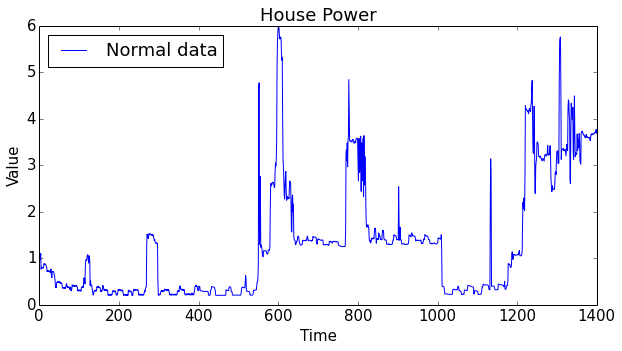

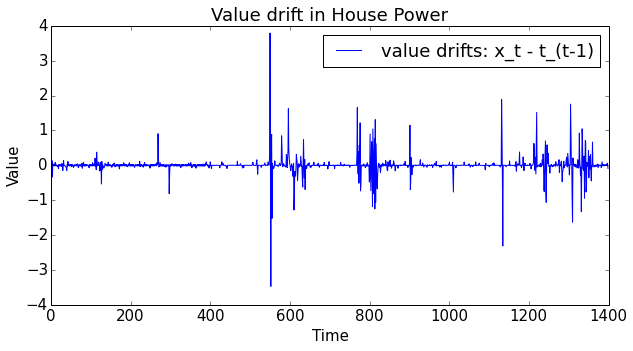

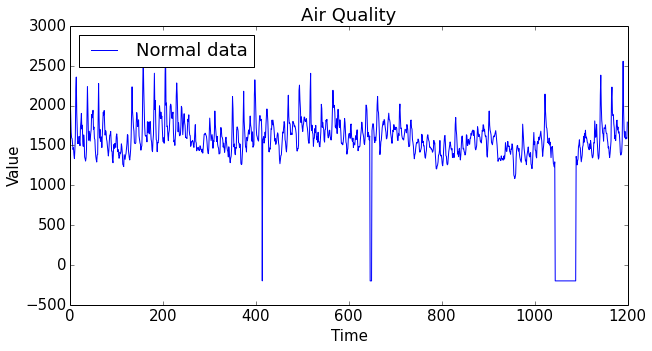

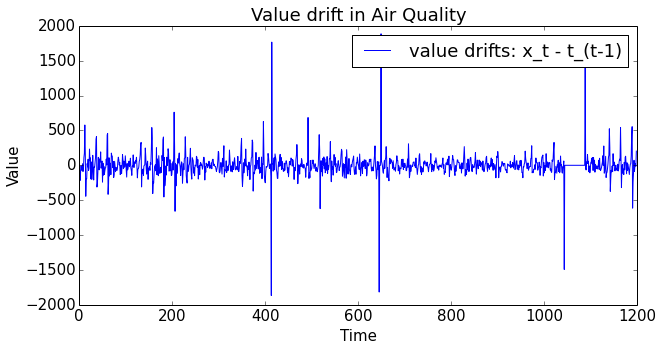

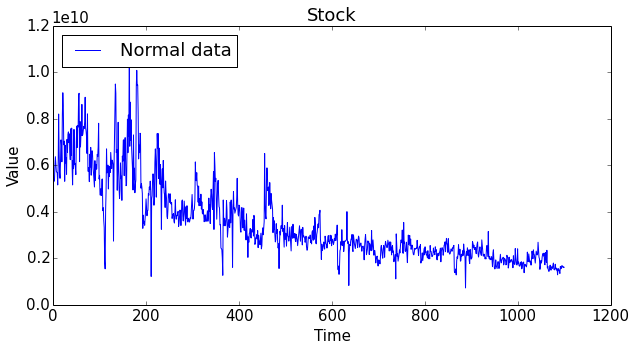

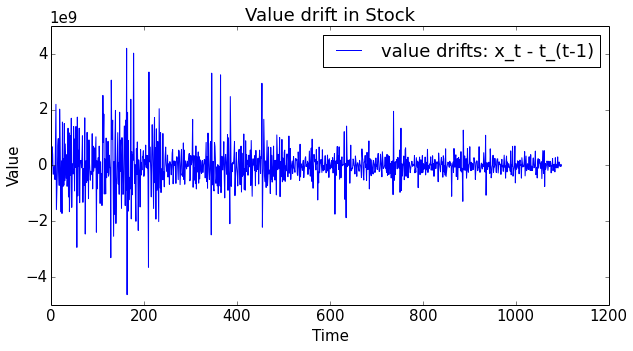

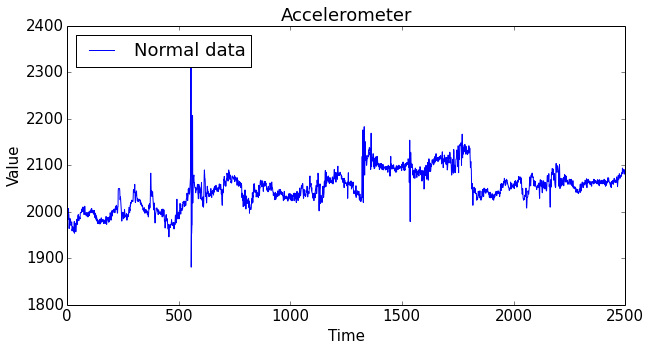

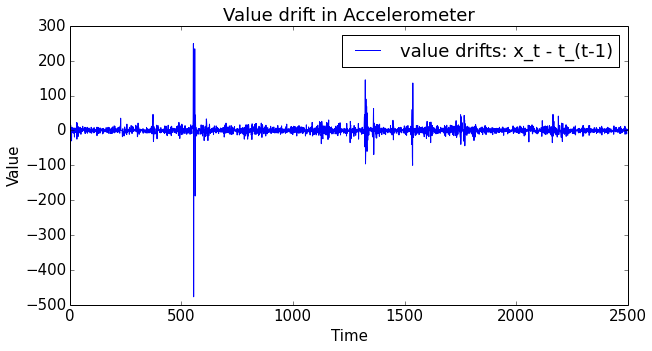

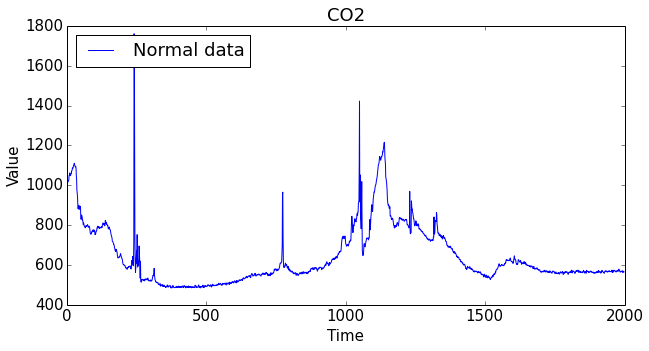

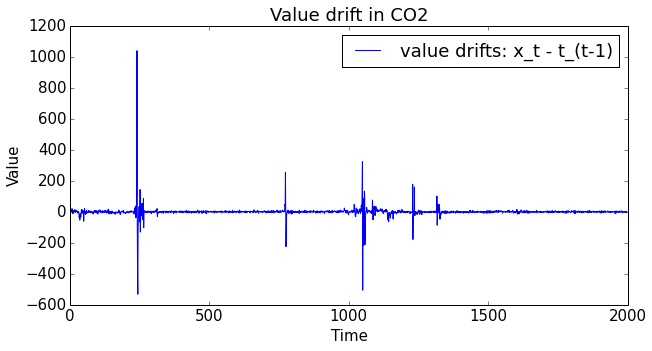

In [4]:
# load unlabelled data

ts_arr=[] 
tp_arr=[]
ts_flag_arr=[]
ts_cpt_arr=[]
yrange_arr=[]


dataset_names=[ "House Power","Air Quality", "Stock","Accelerometer", "CO2"  ]

tmpts,tmpt = load_dataset("/home/guo/rnn_changePoint/dataset/"+"house-power.csv", "Global_active_power", 4600, 6000, ';'\
                                 ,True)

ts_arr.append( tmpts ) 
tp_arr.append(  tmpt)
ts_flag_arr.append( [0]*(len( tmpts) )  )
ts_cpt_arr.append([])
yrange_arr.append([0, 6]  )


tmpts,tmpt= load_dataset("/home/guo/rnn_changePoint/dataset/"+"air-quality.csv","PT08.S4(NO2)", 3000,4200,';', False)

ts_arr.append( tmpts ) 
tp_arr.append(  tmpt)
ts_flag_arr.append( [0]*(len( tmpts) )  )
ts_cpt_arr.append([])
yrange_arr.append([-500, 3000]  )


tmpts,tmpt = load_dataset("/home/guo/rnn_changePoint/dataset/"+"stock.csv","Volume",1700, 2800,',', False)

ts_arr.append( tmpts ) 
tp_arr.append(  tmpt)
ts_flag_arr.append( [0]*(len( tmpts) )  )
ts_cpt_arr.append([])
yrange_arr.append([0, 1.2e10]  )


tmpts,tmpt = load_dataset("/home/guo/rnn_changePoint/dataset/"+\
                            "Activity Recognition from Single Chest-Mounted Accelerometer/"
                              +"1.csv",  '2153' ,147500,150000 ,',', False)

ts_arr.append( tmpts ) 
tp_arr.append(  tmpt)
ts_flag_arr.append( [0]*(len( tmpts) )  )
ts_cpt_arr.append([])
yrange_arr.append([1800, 2400]  )


tmpts,tmpt = load_dataset("/home/guo/rnn_changePoint/dataset/"+\
                            "occupancy_data/"
                              +"datatest2.txt","CO2" , 1, 2000 ,',', False)

ts_arr.append( tmpts ) 
tp_arr.append(  tmpt)
ts_flag_arr.append( [0]*(len( tmpts) )  )
ts_cpt_arr.append([])
yrange_arr.append([400, 1800]  )





#  plot unlabelled data
tmpcnt = len(ts_arr)
for i in range(tmpcnt):
    plot_plain(tp_arr[i] , ts_arr[i], dataset_names[i])

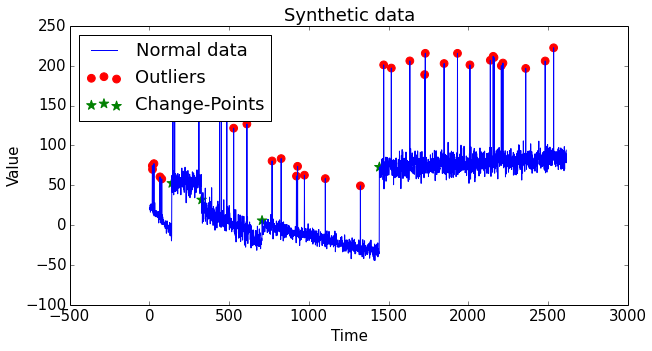

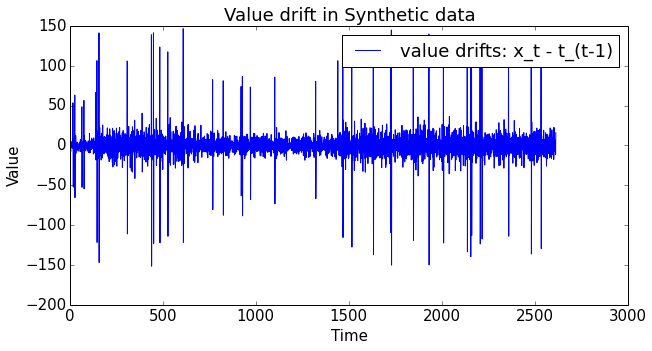

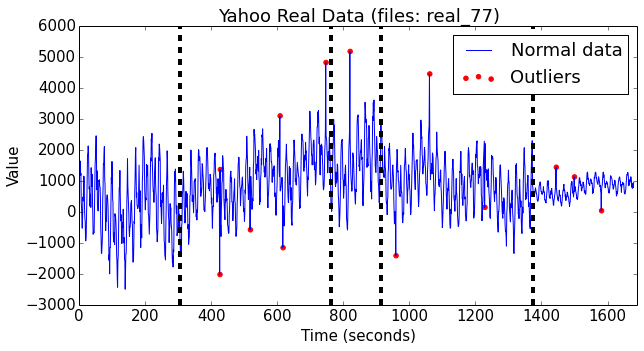

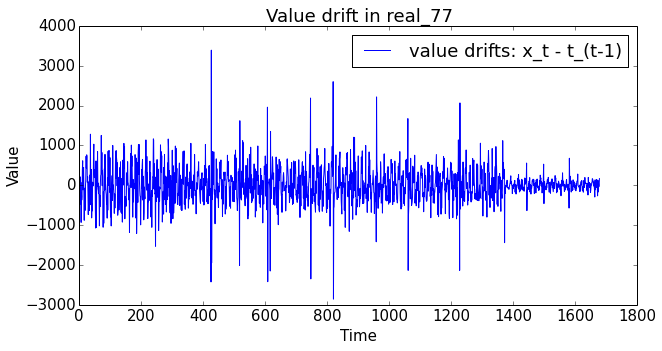

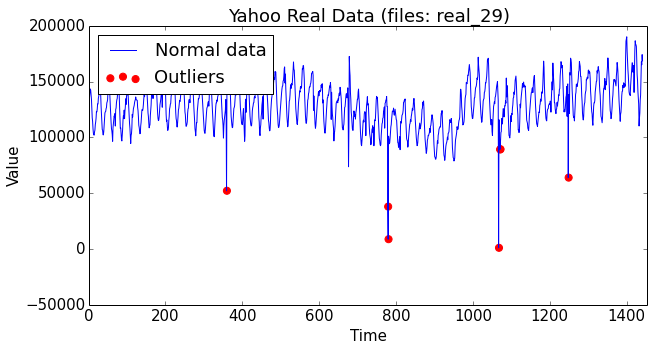

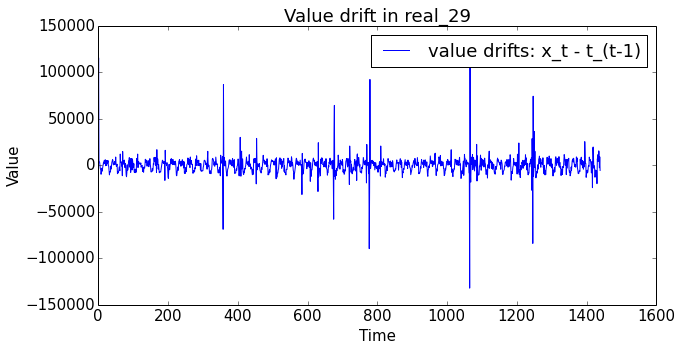

In [4]:
# load labelled data
ts_arr=[] 
tp_arr=[]
ts_flag_arr=[]
ts_cpt_arr=[]
yrange_arr=[]

dataset_names=[ "Synthetic","YSyn", "YReal"]

# ---- synthetic data ----------
tmpdf= pd.read_csv( "/home/guo/rnn_changePoint/dataset/synthetic/"+"syn_dta_trend7.csv" ,\
                   sep=',')
col = tmpdf.columns

ts = list(tmpdf[ col[0] ])
ts = [float(i)  for i in ts]
tmp_flag= list(tmpdf[ col[2] ])

cp= tmpdf[ col[1] ]
cp = list(zip(cp, range( len(ts) )))
cp_t = [  i[1]   for i in cp if i[0]==1]
cp_val = [  ts[i] for i in cp_t]

out=tmpdf[ col[2] ]
out =list( zip(out, range( len(ts) )))
out_t = [  i[1]   for i in out if i[0]==1]
out_val = [  ts[i] for i in out_t]

plot_outlier_cp( range(len(ts)), ts, out_t, out_val, cp_t,cp_val, 'Synthetic data')

ts_arr.append(ts)
ts_flag_arr.append(tmp_flag)

ts_cpt_arr.append( cp_t  )
yrange_arr.append([-100, 250]  )

# -----------------------------------------


# YAHOO SYN
tmpts, tmpts_flag, cpt = yahooSyn_load_data_plot( 77, \
                    "/home/guo/Downloads/ydata-labeled-time-series-anomalies-v1_0/"+\
                        "A4Benchmark/A4Benchmark-TS")
# 77
# 85

# YAHOO REAL


ts_arr.append(tmpts)
ts_flag_arr.append(tmpts_flag)
ts_cpt_arr.append(cpt)
yrange_arr.append([-3000, 6000]  )

# -----------------------------------------

dta_folder="/home/guo/Downloads/ydata-labeled-time-series-anomalies-v1_0/A1Benchmark/real_"
tmpts, tmpts_flag = yahoo_load_data(29, dta_folder)

ts_arr.append(tmpts)
ts_flag_arr.append(tmpts_flag)
ts_cpt_arr.append([])
yrange_arr.append([-50000, 250000]  )


In [5]:
# block2: data pre-processing

# re-organize the data to the format for feeding into the RNN 

def extract_load_data( ts_df, st_idx, ed_idx):
    tmpdta = ts_df.iloc[st_idx: ed_idx]
    cnt= len(tmpdta)
    tmpx=[]
    tmpy=[]
    for i in range(cnt-1):
        tmpx.append( tmpdta.iloc[i].as_matrix() )
        tmpy.append( tmpdta.iloc[i+1].as_matrix() )

    return tmpx, tmpy, tmpdta.iloc[cnt-1].as_matrix()

def format_timeseries_rnn(ts):
    tmptrnx =[]
    tmptrny =[]
    
    ts_df= pd.DataFrame(ts)
    
    tmpPre = 0
    tmpCur = len(ts)
    
    tmpx,tmpy, tmpy1 = extract_load_data( ts_df, tmpPre,tmpCur)
    tmptrnx.append(tmpx)
    tmptrny.append(tmpy)
    
    # qualified format for rnn
    dtax = np.array( tmptrnx )
    dtay = np.array( tmptrny )

#     print dtax.shape, dtay.shape
    return dtax, dtay

In [6]:
# block3:  RNN configureation

hidden_neurons = 450

# learning rate
lr_val = 0.001

# all the available optimizers
sgd = SGD(lr= lr_val, momentum=0.03, decay=0.0, nesterov=True)
rms = RMSprop(lr= lr_val, rho=0.9, epsilon=1e-06)

#Keras says: it is recommended to leave the parameters of this optimizer 
# at their default values for the two optimizers below
adagrad = Adagrad(lr=0.01, epsilon=1e-06)
adadelta = Adadelta(lr=1.0,rho=0.95,epsilon=1e-06)

adam =  Adam(lr= lr_val, beta_1=0.9, beta_2=0.999, epsilon=1e-08)
adamax = Adamax(lr= lr_val, beta_1=0.9, beta_2=0.999, epsilon=1e-08)


opt_list=[ sgd, rms, adagrad, adadelta, adam, adamax ]
opt_namelist=[ "SGD with Momentum","RMSprop","ADAGRAD","ADADELTA","ADAM","ADAMAX" ]


loss_func = "mean_squared_error"
conf_level=0.05
winsize=10
nmse_arr=[1,2,3]

In [8]:
#block4: define a function for training RNN
def test_result_plot(test_tstamp,testx, testy, testyh, method_name, ybound,\
                     dataset_name, save_bool, cp_tstamp, win_size):
    
    fig = plt.figure()
    matplotlib.rcParams.update({'font.size': 15})
    figure_size= ( 15.4,7)
    fig.set_size_inches( figure_size )
    
    plt.title("Online Prediction by "+ method_name+ " on "+ dataset_name)
    plt.ylabel('Value')
    plt.xlabel('Time')

    plt.plot( test_tstamp, testyh, label='Prediction', color='blue', linewidth=2.0)
    plt.scatter( test_tstamp, testy, label='Truth', marker='.', color='green',\
               s=60)
#     plt.scatter( list(outlier_tdf['timestamp']),list(outlier_tdf['value']), color='red',\
#              label='Outliers')

    if len(cp_tstamp) >0:
        tmpcp= [ i  for i in cp_tstamp]
        for i in tmpcp:
            plt.axvline(x=i, color='k',ls='dashed', linewidth=2.0)

    
    plt.legend( loc='upper left',fontsize=15 )

    axes = plt.gca()
    axes.set_xlim([1, len(testx)+10])
    
    if len(ybound)!=0:
        axes.set_ylim([ ybound[0],ybound[1] ])

    cnt= len(testy)

    nmse = sqrt(sum([(testy[i]- testyh[i])*(testy[i]- testyh[i]) \
                     for i in range(cnt)])*1.0/cnt)
    print 'Normalzied MSE using '+ method_name + ' on '+ dataset_name + ': ', nmse

    if save_bool == True:
        fig.savefig('../res/'+method_name+'-'+dataset_name+'.pdf',\
                format='pdf', bbox_inches='tight')
    
    return nmse

    
def prediction_para_plot( tst_y, pred_y_lr, method_name, para_name,para_list,noisyOrClean):
    
    fig = plt.figure()
    figure_size= ( 15.4,7)
    fig.set_size_inches( figure_size )
    
    plt.title('Online prediction by RNN trained using '+ method_name + ' on '+ noisyOrClean)
    plt.ylabel('Value')
    plt.xlabel('Time')

    plt.plot(tst_y, label='Truth')

    print ('Numerical errors on '+ method_name + ':' )
    
    for i in range(len(para_list)):
        plt.plot(pred_y_lr[i], label= para_name + str( para_list[i] ) )
    
        cnt= len(tst_y)
        nmse = sqrt(sum([(tst_y[j]- pred_y_lr[i][j])*(tst_y[j]-  pred_y_lr[i][j] )\
                         for j in range(cnt)])*1.0/cnt  )
        print 'Normalzied MSE on '+ para_name + str( para_list[i])+':', nmse
    
    plt.legend( loc='upper left',fontsize=15 )

    axes = plt.gca()
    axes.set_xlim([1, len(tst_y)+10])
#     axes.set_ylim([-2000,38000])

    
# continusly feed the data into RNN to update the model
def rl_train_rnn(dtax, dtay, optimizer_config, loss_func, outlier_flag, regular_para):
    
    timesteps =1 
    in_out_neurons = 1
    test_step=2
    
    trn_size= dtax.shape[1]-3
    trnx = dtax 
    trny = dtay 
    
    testx=[]
    testy=[]
    testyh=[]
    test_t=[]

    rl_model = Sequential()
    rl_model.add(LSTM(hidden_neurons, return_sequences=True, stateful= True,\
                  batch_input_shape = (1,timesteps, in_out_neurons ) ,\
                      W_regularizer=l2( regular_para ) ))
#     rl_model.add(Activation("relu")) 
    rl_model.add(TimeDistributedDense(output_dim= in_out_neurons ) )
    rl_model.add(Activation("linear")) 

    rl_model.compile(loss= loss_func, optimizer= optimizer_config )

    for i in range(trn_size):
        cur_trnx= trnx[:,i:i+1,:] 
        cur_trny= trny[:,i:i+1,:]
    
        rl_model.train_on_batch(cur_trnx,cur_trny) 
        
    
        if  i>= winsize+1 and outlier_flag[i+2]!=1 and outlier_flag[i+1]!=1 :
            vali_testx=  trnx[:, i+1:i+2,:]
            pred_test = rl_model.predict_on_batch( vali_testx )[0][0][0]
        
            testx.append( vali_testx[0][0][0] )
            testy.append( trny[:, i+1:i+2,:][0][0][0] )
            testyh.append( pred_test[0]   )
            
            test_t.append(i+1)
    
    return test_t, testx, testy, testyh



def sliding_window_statistic(cur_pos, rnn_model, winsize, dataX, dataY):
    
    tmpmean =0.0
    tmpsq =0.0
    tmpvar=0.0
    tmpres_list=[]
    
    for i in range(  cur_pos-winsize , cur_pos):
        
        cur_trnx= dataX[:,i:i+1,:] 
        cur_trny= dataY[:,i:i+1,:]
        
        cur_pred = rnn_model.predict_on_batch( cur_trnx )[0][0][0]
        
        tmpresi =  cur_trny - cur_pred
        
        tmpres_list.append(tmpresi)
        
        tmpmean= tmpmean+tmpresi
        tmpsq= tmpsq + tmpresi*tmpresi
    
    tmpmean= tmpmean/(winsize*1.0)
    tmpvar = sum([(tmpmean-i)**2  for i in tmpres_list])/( (winsize-1.0)*1.0) 
    
    return tmpmean, tmpvar
    

def skip_train_rnn(dtax, dtay, optimizer_config, loss_func, outlier_flag, regular_para):
    
    timesteps =1 
    in_out_neurons = 1
    test_step=2
    
    trn_size= dtax.shape[1]-3
    trnx = dtax 
    trny = dtay 
    
    testx=[]
    testy=[]
    testyh=[]
    test_t=[]
    
    
    resi_mean= trnx[:,0:1,:][0][0][0]
    resi_sqr = trnx[:,0:1,:][0][0][0]**2
    resi_var= 2.0
    
    seg_cnt=1

    rl_model = Sequential()
    rl_model.add(LSTM(hidden_neurons, return_sequences=True, stateful= True,\
                  batch_input_shape = (1,timesteps, in_out_neurons ) ,\
                      W_regularizer=l2( regular_para ) ))
#     rl_model.add(Activation("relu")) 

    rl_model.add(TimeDistributedDense(output_dim= in_out_neurons ) )
    rl_model.add(Activation("linear")) 

    rl_model.compile(loss= loss_func, optimizer= optimizer_config )

    for i in range(trn_size):
        cur_trnx= trnx[:,i:i+1,:] 
        cur_trny= trny[:,i:i+1,:]
        
        if i< winsize+1:
            rl_model.train_on_batch(cur_trnx,cur_trny) 
            continue

        curmean, curvar = sliding_window_statistic(i, rl_model, winsize, \
                                                   dtax, dtay)
        
        
        cur_pred = rl_model.predict_on_batch( cur_trnx )[0][0][0]
        tmpresi = cur_trny[0][0][0] - cur_pred[0]
        
        
        tmp_zval = (tmpresi- curmean )*1.0 / sqrt(curvar)
        tmp_pro_conve =  st.norm.cdf( tmp_zval)

        if not ( tmp_pro_conve>=(1-conf_level) or tmp_pro_conve<= conf_level):
            rl_model.train_on_batch(cur_trnx,cur_trny) 
            
            cur_pred = rl_model.predict_on_batch( cur_trnx )[0][0][0]
            tmpresi = cur_trny[0][0][0] - cur_pred[0]        
        
            resi_mean =  resi_mean* seg_cnt*1.0/(seg_cnt+1)+ tmpresi/(seg_cnt+1)
            resi_sqr = resi_sqr*seg_cnt*1.0/(seg_cnt+1) + tmpresi*tmpresi/(seg_cnt+1)
            resi_var= resi_sqr - resi_mean* resi_mean
        
            seg_cnt = seg_cnt+1
        
        if  outlier_flag[i+2]!=1 and outlier_flag[i+1]!=1 :
            vali_testx=  trnx[:, i+1:i+2,:]
            pred_test = rl_model.predict_on_batch( vali_testx )[0][0][0]
        
            testx.append( vali_testx[0][0][0] )
            testy.append( trny[:, i+1:i+2,:][0][0][0] )
            testyh.append( pred_test[0] )
            
            test_t.append(i+1)
    
    return test_t,testx, testy, testyh

def scc_train_rnn(dtax, dtay, optimizer_config, loss_func, outlier_flag, regular_para):
    
    timesteps =1 
    in_out_neurons = 1
    test_step=2
    
    trn_size= dtax.shape[1]-3
    trnx = dtax 
    trny = dtay 
    
    testx=[]
    testy=[]
    testyh=[]
    test_t=[]
    
    resi_mean= trnx[:,0:1,:][0][0][0]
    resi_sqr = trnx[:,0:1,:][0][0][0]**2
    resi_var= 2.0
    
    chart_val = trnx[:,0:1,:][0][0][0]
    chart_lambda = 0.8
    chart_times=3.0
    
    seg_cnt=1
    
    rl_model = Sequential()
    rl_model.add(LSTM(hidden_neurons, return_sequences=True, stateful= True,\
                  batch_input_shape = (1, timesteps, in_out_neurons ) ,\
                      W_regularizer=l2( regular_para ) ))
#     rl_model.add(Activation("relu")) 

    rl_model.add(TimeDistributedDense(output_dim= in_out_neurons ) )
    rl_model.add(Activation("linear")) 

    rl_model.compile(loss= loss_func, optimizer= optimizer_config )

    for i in range(trn_size):
        cur_trnx= trnx[:,i:i+1,:] 
        cur_trny= trny[:,i:i+1,:]
        
        
        if i< winsize+1:
            rl_model.train_on_batch(cur_trnx,cur_trny) 
            continue

        curmean, curvar = sliding_window_statistic(i, rl_model, winsize, \
                                                   dtax, dtay)
        
        
        cur_pred = rl_model.predict_on_batch( cur_trnx )[0][0][0]
        tmpresi = cur_trny[0][0][0] - cur_pred[0]
        
        
        tmp_zval = (tmpresi-curmean )*1.0 / sqrt(curvar)
        tmp_pro_conve =  st.norm.cdf( tmp_zval)
        
        
        chart_val = chart_lambda*chart_val + (1- chart_lambda)*tmp_zval
        chart_up = 0.0 + chart_times*sqrt(resi_var)/sqrt(seg_cnt)*sqrt( chart_lambda/(2.0-chart_lambda) )
        chart_down= 0.0 - chart_times*sqrt(resi_var)/sqrt(seg_cnt)*sqrt( chart_lambda/(2.0-chart_lambda) )
        

        if not (tmp_pro_conve>(1-conf_level) or tmp_pro_conve< conf_level):
            rl_model.train_on_batch(cur_trnx,cur_trny) 
            
            cur_pred = rl_model.predict_on_batch( cur_trnx )[0][0][0]
            tmpresi = cur_trny[0][0][0] - cur_pred[0]        
        
            resi_mean =  resi_mean* seg_cnt*1.0/(seg_cnt+1)+ tmpresi/(seg_cnt+1)
            resi_sqr = resi_sqr*seg_cnt*1.0/(seg_cnt+1) + tmpresi*tmpresi/(seg_cnt+1)
            resi_var= resi_sqr - resi_mean* resi_mean
            seg_cnt = seg_cnt+1
            
        elif  chart_val<=chart_up and chart_val >=chart_down:
            
            rl_model.train_on_batch(cur_trnx,cur_trny) 
            
            cur_pred = rl_model.predict_on_batch( cur_trnx )[0][0][0]
            tmpresi = cur_trny[0][0][0] - cur_pred[0]        
        
            resi_mean =  resi_mean* seg_cnt*1.0/(seg_cnt+1)+ tmpresi/(seg_cnt+1)
            resi_sqr = resi_sqr*seg_cnt*1.0/(seg_cnt+1) + tmpresi*tmpresi/(seg_cnt+1)
            resi_var= resi_sqr - resi_mean* resi_mean
            seg_cnt = seg_cnt+1
        else:
            chart_val = tmp_zval
            
        
        if  outlier_flag[i+2]!=1 and outlier_flag[i+1]!=1 :
            vali_testx=  trnx[:, i+1:i+2,:]
            pred_test = rl_model.predict_on_batch( vali_testx )[0][0][0]
        
            testx.append( vali_testx[0][0][0] )
            testy.append( trny[:, i+1:i+2,:][0][0][0] )
            testyh.append( pred_test[0]   )
            
            test_t.append(i+1)
    
    return test_t,testx, testy, testyh

In [13]:
#  choose learning rate of each appraoch for each UNLABELLED dataset

tmpcnt = len(ts_arr)
for i in range(tmpcnt):
    
    print "-------------- expeirments on UNLABBED ", dataset_names[i], "-------------------"
    
    dtax, dtay = format_timeseries_rnn( ts_arr[i] )
    lr_vals=[0.0001,0.0005, 0.001, 0.005, 0.01 ]

# set of more fine learing rates 
# lr_vals=[ 0.003, 0.005,0.007,0.009 ]

    pred_y_lr_noise=[]
    y_noise=[]
    ts_flag = [0]*len( ts_arr[i] )

    print "RTRL:"
    for tmp_lr in lr_vals:
        sgd = SGD(lr= tmp_lr, momentum=0.03, decay=0.0, nesterov=True)
        rl_tst_x, rl_tst_y, rl_tst_pred_y = rl_train_rnn(dtax, dtay, sgd, loss_func,ts_flag,0.0001)
        
        pred_y_lr_noise.append(rl_tst_pred_y)
        y_noise.append( rl_tst_y )
    
        cnt= len(rl_tst_y)
        print len(rl_tst_y), len(rl_tst_pred_y)
        nmse = sqrt(sum([(rl_tst_y[i]- rl_tst_pred_y[i])*(rl_tst_y[i]- rl_tst_pred_y[i])\
                         for i in range(cnt)])*1.0/cnt)
        print 'Normalzied MSE '+ str(tmp_lr) +  ' : ', nmse

    print "SKIP:"
    for tmp_lr in lr_vals:
        sgd = SGD(lr= tmp_lr, momentum=0.03, decay=0.0, nesterov=True)
        sk_tst_x, sk_tst_y, sk_tst_pred_y = skip_train_rnn(dtax, dtay, sgd, loss_func,ts_flag,0.0001)
        pred_y_lr_noise.append( sk_tst_pred_y)
        y_noise.append( sk_tst_y )
    
        cnt= len( sk_tst_y)
        print len( sk_tst_y), len(sk_tst_pred_y)
        nmse = sqrt(sum([(sk_tst_y[i]- sk_tst_pred_y[i])*( sk_tst_y[i]- sk_tst_pred_y[i])\
                         for i in range(cnt)])*1.0/cnt)
        print 'Normalzied MSE '+ str(tmp_lr) +  ' : ', nmse
        
    print "Statistical control chart:"   
    for tmp_lr in lr_vals:
        sgd = SGD(lr= tmp_lr, momentum=0.03, decay=0.0, nesterov=True)
        sc_tst_x, sc_tst_y, sc_tst_pred_y = scc_train_rnn(dtax, dtay, sgd, loss_func,ts_flag,0.0001)
        pred_y_lr_noise.append( sc_tst_pred_y)
        y_noise.append( sc_tst_y )
    
        cnt= len( sc_tst_y)
        print len(sc_tst_y), len( sc_tst_pred_y)
        nmse = sqrt(sum([(sc_tst_y[i]- sc_tst_pred_y[i])*( sc_tst_y[i]- sc_tst_pred_y[i])\
                         for i in range(cnt)])*1.0/cnt)
        print 'Normalzied MSE '+ str(tmp_lr) +  ' : ', nmse
        

# -------------- expeirments on UNLABBED  House Power -------------------
# RTRL:
# 1385 1385
# Normalzied MSE 0.0001 :  0.803622355083
# 1385 1385
# Normalzied MSE 0.0005 :  0.499646785207
# 1385 1385
# Normalzied MSE 0.001 :  0.433794732765
# 1385 1385
# Normalzied MSE 0.005 :  0.332334037544
# 1385 1385
# Normalzied MSE 0.01 :  0.30344677525
# SKIP:
# 1385 1385
# Normalzied MSE 0.0001 :  0.960003442036
# 1385 1385
# Normalzied MSE 0.0005 :  0.562001265079
# 1385 1385
# Normalzied MSE 0.001 :  0.512137480396
# 1385 1385
# Normalzied MSE 0.005 :  0.400896139442
# 1385 1385
# Normalzied MSE 0.01 :  0.377152643221
# Statistical control chart:
# 1385 1385
# Normalzied MSE 0.0001 :  0.893821550145
# 1385 1385
# Normalzied MSE 0.0005 :  0.577429954449
# 1385 1385
# Normalzied MSE 0.001 :  0.490401252656
# 1385 1385
# Normalzied MSE 0.005 :  0.392190655507
# 1385 1385
# Normalzied MSE 0.01 :  0.383394461424
# -------------- expeirments on UNLABBED  Air Quality -------------------
# RTRL:
# 1185 1185
# Normalzied MSE 0.0001 :  302.18232209
# 1185 1185
# Normalzied MSE 0.0005 :  216.948416402
# 1185 1185
# Normalzied MSE 0.001 :  210.10324325
# 1185 1185
# Normalzied MSE 0.005 :  213.634491935
# 1185 1185
# Normalzied MSE 0.01 :  nan
# SKIP:
# 1185 1185
# Normalzied MSE 0.0001 :  318.883469319
# 1185 1185
# Normalzied MSE 0.0005 :  226.176388687
# 1185 1185
# Normalzied MSE 0.001 :  218.886269577
# 1185 1185
# Normalzied MSE 0.005 :  201.97606059
# 1185 1185
# Normalzied MSE 0.01 :  nan
# Statistical control chart:
# 1185 1185
# Normalzied MSE 0.0001 :  298.381699319
# 1185 1185
# Normalzied MSE 0.0005 :  225.47979555
# 1185 1185
# Normalzied MSE 0.001 :  218.265273274
# 1185 1185
# Normalzied MSE 0.005 :  199.732567148
# 1185 1185
# Normalzied MSE 0.01 :  nan
# -------------- expeirments on UNLABBED  Stock -------------------
# RTRL:
# 1085 1085
# Normalzied MSE 0.0001 :  1215166794.81
# 1085 1085
# Normalzied MSE 0.0005 :  771184699.34
# 1085 1085
# Normalzied MSE 0.001 :  675760509.439
# 1085 1085
# Normalzied MSE 0.005 :  660969171.393
# 1085 1085
# Normalzied MSE 0.01 :  1140139921.57
# SKIP:
# 1085 1085
# Normalzied MSE 0.0001 :  1284676219.89
# 1085 1085
# Normalzied MSE 0.0005 :  802913508.197
# 1085 1085
# Normalzied MSE 0.001 :  746141401.261
# 1085 1085
# Normalzied MSE 0.005 :  688051065.827
# 1085 1085
# Normalzied MSE 0.01 :  969493299.207
# Statistical control chart:
# 1085 1085
# Normalzied MSE 0.0001 :  1189004511.92
# 1085 1085
# Normalzied MSE 0.0005 :  763438605.847
# 1085 1085
# Normalzied MSE 0.001 :  684156228.77
# 1085 1085
# Normalzied MSE 0.005 :  671404591.972
# 1085 1085
# Normalzied MSE 0.01 :  1089765703.22
# -------------- expeirments on UNLABBED  Accelerometer -------------------
# RTRL:
# 2485 2485
# Normalzied MSE 0.0001 :  175.362825882
# 2485 2485
# Normalzied MSE 0.0005 :  37.5631237301
# 2485 2485
# Normalzied MSE 0.001 :  16.9027303655
# 2485 2485
# Normalzied MSE 0.005 :  15.4772079807
# 2485 2485
# Normalzied MSE 0.01 :  26.5626766312
# SKIP:
# 2485 2485
# Normalzied MSE 0.0001 :  179.853245194
# 2485 2485
# Normalzied MSE 0.0005 :  30.0282548458
# 2485 2485
# Normalzied MSE 0.001 :  18.5086280354
# 2485 2485
# Normalzied MSE 0.005 :  14.8941756018
# 2485 2485
# Normalzied MSE 0.01 :  26.9209203039
# Statistical control chart:
# 2485 2485
# Normalzied MSE 0.0001 :  173.811615094
# 2485 2485
# Normalzied MSE 0.0005 :  32.9044182897
# 2485 2485
# Normalzied MSE 0.001 :  17.1595011372
# 2485 2485
# Normalzied MSE 0.005 :  14.9478884011
# 2485 2485
# Normalzied MSE 0.01 :  40.3609474264
# -------------- expeirments on UNLABBED  CO2 -------------------
# RTRL:
# 1984 1984
# Normalzied MSE 0.0001 :  111.288010315
# 1984 1984
# Normalzied MSE 0.0005 :  57.658491703
# 1984 1984
# Normalzied MSE 0.001 :  44.6740237924
# 1984 1984
# Normalzied MSE 0.005 :  36.0944452565
# 1984 1984
# Normalzied MSE 0.01 :  66.0570811086
# SKIP:
# 1984 1984
# Normalzied MSE 0.0001 :  132.140670644
# 1984 1984
# Normalzied MSE 0.0005 :  62.2536463288
# 1984 1984
# Normalzied MSE 0.001 :  53.2460174502
# 1984 1984
# Normalzied MSE 0.005 :  49.0226193603
# 1984 1984
# Normalzied MSE 0.01 :  62.2387436381
# Statistical control chart:
# 1984 1984
# Normalzied MSE 0.0001 :  123.899392342
# 1984 1984
# Normalzied MSE 0.0005 :  65.9786499042
# 1984 1984
# Normalzied MSE 0.001 :  53.7015268384
# 1984 1984
# Normalzied MSE 0.005 :  48.1875562162
# 1984 1984
# Normalzied MSE 0.01 :  59.0984247963

-------------- expeirments on UNLABBED  House Power -------------------
RTRL:
1385 1385
Normalzied MSE 0.0001 :  0.803622355083
1385 1385
Normalzied MSE 0.0005 :  0.499646785207
1385 1385
Normalzied MSE 0.001 :  0.433794732765
1385 1385
Normalzied MSE 0.005 :  0.332334037544
1385 1385
Normalzied MSE 0.01 :  0.30344677525
SKIP:
1385 1385
Normalzied MSE 0.0001 :  0.960003442036
1385 1385
Normalzied MSE 0.0005 :  0.562001265079
1385 1385
Normalzied MSE 0.001 :  0.512137480396
1385 1385
Normalzied MSE 0.005 :  0.400896139442
1385 1385
Normalzied MSE 0.01 :  0.377152643221
Statistical control chart:
1385 1385
Normalzied MSE 0.0001 :  0.893821550145
1385 1385
Normalzied MSE 0.0005 :  0.577429954449
1385 1385
Normalzied MSE 0.001 :  0.490401252656
1385 1385
Normalzied MSE 0.005 :  0.392190655507
1385 1385
Normalzied MSE 0.01 :  0.383394461424
-------------- expeirments on UNLABBED  Air Quality -------------------
RTRL:
1185 1185
Normalzied MSE 0.0001 :  302.18232209
1185 1185
Normalzied MSE 0

In [ ]:
#  choose learning rate of each appraoch for each LABELLED dataset

tmpcnt = len(ts_arr)
for dataset_idx in range(tmpcnt-1,tmpcnt):
    
    print "-------------- expeirments on LABBED ", dataset_names[dataset_idx], "-------------------"
    
    dtax, dtay = format_timeseries_rnn( ts_arr[dataset_idx] )
    lr_vals=[0.0001,0.0005, 0.001, 0.005, 0.01 ]

# set of more fine learing rates 
# lr_vals=[ 0.003, 0.005,0.007,0.009 ]

    pred_y_lr_noise=[]
    y_noise=[]
    

    print "RTRL:"
    for tmp_lr in lr_vals:
        sgd = SGD(lr= tmp_lr, momentum=0.03, decay=0.0, nesterov=True)
        rl_tst_x, rl_tst_y, rl_tst_pred_y = rl_train_rnn(dtax, dtay, sgd, loss_func,\
                                                         ts_flag_arr[dataset_idx],0.0001)
            
        cnt= len(rl_tst_y)
        print len(rl_tst_y), len(rl_tst_pred_y)
        nmse = sqrt(sum([(rl_tst_y[i]- rl_tst_pred_y[i])*(rl_tst_y[i]- rl_tst_pred_y[i])\
                         for i in range(cnt)])*1.0/cnt)
        print 'Normalzied MSE '+ str(tmp_lr) +  ' : ', nmse

    print "SKIP:"
    for tmp_lr in lr_vals:
        sgd = SGD(lr= tmp_lr, momentum=0.03, decay=0.0, nesterov=True)
        sk_tst_x, sk_tst_y, sk_tst_pred_y = skip_train_rnn(dtax, dtay, sgd, loss_func,\
                                                           ts_flag_arr[dataset_idx],\
                                                           0.0001)
     
        cnt= len( sk_tst_y)
        print len( sk_tst_y), len(sk_tst_pred_y)
        nmse = sqrt(sum([(sk_tst_y[i]- sk_tst_pred_y[i])*( sk_tst_y[i]- sk_tst_pred_y[i])\
                         for i in range(cnt)])*1.0/cnt)
        print 'Normalzied MSE '+ str(tmp_lr) +  ' : ', nmse
        
    print "Statistical control chart:"   
    for tmp_lr in lr_vals:
        sgd = SGD(lr= tmp_lr, momentum=0.03, decay=0.0, nesterov=True)
        sc_tst_x, sc_tst_y, sc_tst_pred_y = scc_train_rnn(dtax, dtay, sgd, loss_func,\
                                                          ts_flag_arr[dataset_idx],0.0001)
    
        cnt= len( sc_tst_y)
        print len(sc_tst_y), len( sc_tst_pred_y)
        nmse = sqrt(sum([(sc_tst_y[i]- sc_tst_pred_y[i])*( sc_tst_y[i]- sc_tst_pred_y[i])\
                         for i in range(cnt)])*1.0/cnt)
        print 'Normalzied MSE '+ str(tmp_lr) +  ' : ', nmse
        
# -------------- expeirments on LABBED  Synthetic -------------------
# RTRL:
# 430 430
# Normalzied MSE 0.0001 :  7.33363697796
# 430 430
# Normalzied MSE 0.0005 :  5.08855213282
# 430 430
# Normalzied MSE 0.001 :  5.17146739983
# 430 430
# Normalzied MSE 0.005 :  6.12348730194
# 430 430
# Normalzied MSE 0.01 :  6.47296872662
# SKIP:
# 430 430
# Normalzied MSE 0.0001 :  7.95905868362
# 430 430
# Normalzied MSE 0.0005 :  5.79465092824
# 430 430
# Normalzied MSE 0.001 :  5.81124414623
# 430 430
# Normalzied MSE 0.005 :  6.42301604678
# 430 430
# Normalzied MSE 0.01 :  6.87734464289
# Statistical control chart:
# 430 430
# Normalzied MSE 0.0001 :  7.96217129551
# 430 430
# Normalzied MSE 0.0005 :  5.78019576103
# 430 430
# Normalzied MSE 0.001 :  5.81610908375
# 430 430
# Normalzied MSE 0.005 :  6.44835681293
# 430 430
# Normalzied MSE 0.01 :  6.96699594211
# -------------- expeirments on LABBED  YSyn -------------------
# RTRL:
# 1643 1643
# Normalzied MSE 0.0001 :  385.803019405
# 1643 1643
# Normalzied MSE 0.0005 :  371.044028419
# 1643 1643
# Normalzied MSE 0.001 :  369.9545768
# 1643 1643
# Normalzied MSE 0.005 :  316.508360598
# 1643 1643
# Normalzied MSE 0.01 :  nan
# SKIP:
# 1643 1643
# Normalzied MSE 0.0001 :  387.806096599
# 1643 1643
# Normalzied MSE 0.0005 :  371.61413787
# 1643 1643
# Normalzied MSE 0.001 :  381.592970263
# 1643 1643
# Normalzied MSE 0.005 :  432.161393073
# 1643 1643
# Normalzied MSE 0.01 :  nan
# Statistical control chart:
# 1643 1643
# Normalzied MSE 0.0001 :  383.666695721
# 1643 1643
# Normalzied MSE 0.0005 :  375.093502365
# 1643 1643
# Normalzied MSE 0.001 :  383.263970016
# 1643 1643
# Normalzied MSE 0.005 :  424.939008014
# 1643 1643
# Normalzied MSE 0.01 :  nan

# -------------- expeirments on LABBED  YReal -------------------
# RTRL:
# 1409 1409
# Normalzied MSE 0.0001 :  2014.28842806
# 1409 1409
# Normalzied MSE 0.0005 :  1394.29481581
# 1409 1409
# Normalzied MSE 0.001 :  1495.87761625
# 1409 1409
# Normalzied MSE 0.005 :  691.243525415
# 1409 1409
# Normalzied MSE 0.01 :  13860.462612
# SKIP:
# 1409 1409
# Normalzied MSE 0.0001 :  2088.96143901
# 1409 1409
# Normalzied MSE 0.0005 :  1064.63043238
# 1409 1409
# Normalzied MSE 0.001 :  912.152026185
# 1409 1409
# Normalzied MSE 0.005 :  714.744300795
# 1409 1409
# Normalzied MSE 0.01 :  6625.34105672
# Statistical control chart:
# 1409 1409
# Normalzied MSE 0.0001 :  2111.83354325
# 1409 1409
# Normalzied MSE 0.0005 :  1123.37420217
# 1409 1409
# Normalzied MSE 0.001 :  885.857694078
# 1409 1409
# Normalzied MSE 0.005 :  711.26963957
# 1409 1409
# Normalzied MSE 0.01 :  2026.12946255

Normalzied MSE using RLSTM on CO2:  35.5543692161


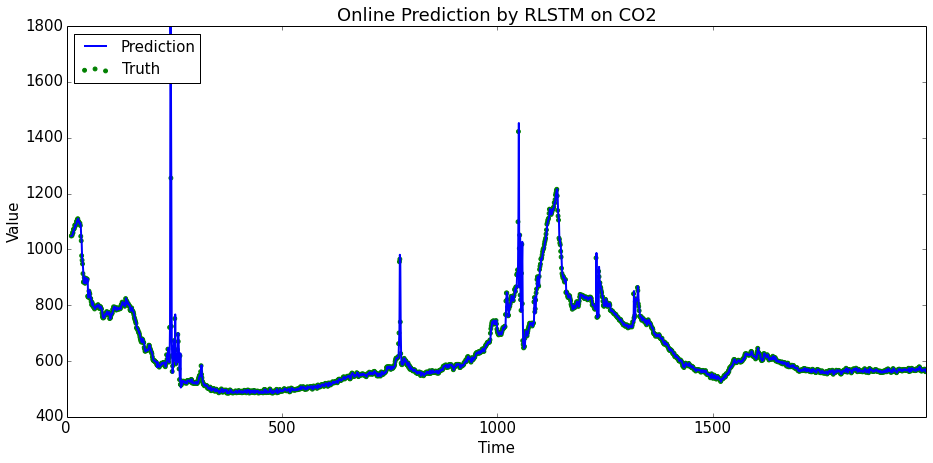

In [20]:
# block7: single run with the best learing rate
dataset_idx=4

dtax, dtay = format_timeseries_rnn( ts_arr[dataset_idx] )

sgd = SGD(lr= 0.005, momentum=0.03, decay=0.0, nesterov=True)
rl_t, rl_tst_x, rl_tst_y, rl_tst_pred_y = rl_train_rnn(dtax, dtay, sgd, loss_func, \
                                                ts_flag_arr[dataset_idx], 0.0001)

tmpmse=test_result_plot(rl_t, rl_tst_x, rl_tst_y, rl_tst_pred_y, "RLSTM" , yrange_arr[dataset_idx], \
                 dataset_names[dataset_idx], True, ts_cpt_arr[dataset_idx], winsize)

nmse_arr[0]=tmpmse

Normalzied MSE using PLSTM on CO2:  49.1137971594


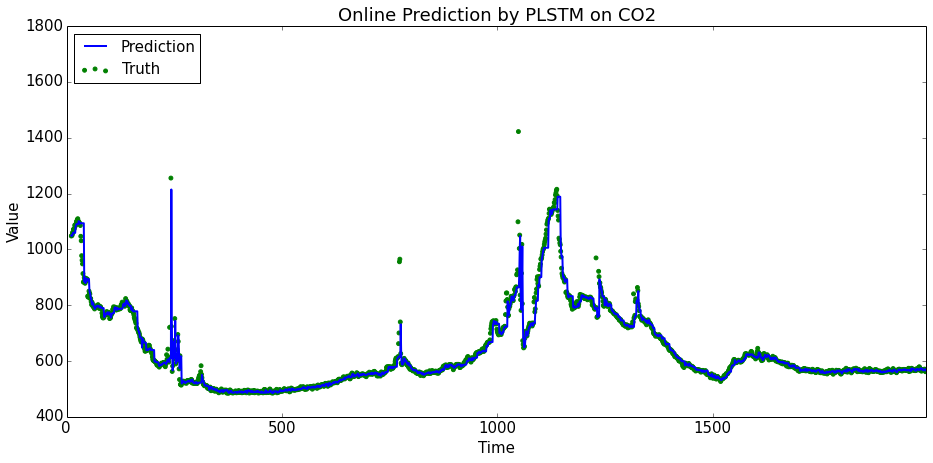

In [21]:
dtax, dtay = format_timeseries_rnn( ts_arr[dataset_idx] )

sgd = SGD(lr= 0.005, momentum=0.03, decay=0.0, nesterov=True)
sk_t, sk_tst_x, sk_tst_y, sk_tst_pred_y= skip_train_rnn(dtax, dtay, sgd, loss_func,\
                                                  ts_flag_arr[dataset_idx], 0.0001)
tmpmse= test_result_plot(sk_t,  sk_tst_x, sk_tst_y, sk_tst_pred_y, "PLSTM" , yrange_arr[dataset_idx], \
                 dataset_names[dataset_idx],True,ts_cpt_arr[dataset_idx], winsize)

nmse_arr[1]=tmpmse

Normalzied MSE using ELSTM on CO2:  40.6170444473


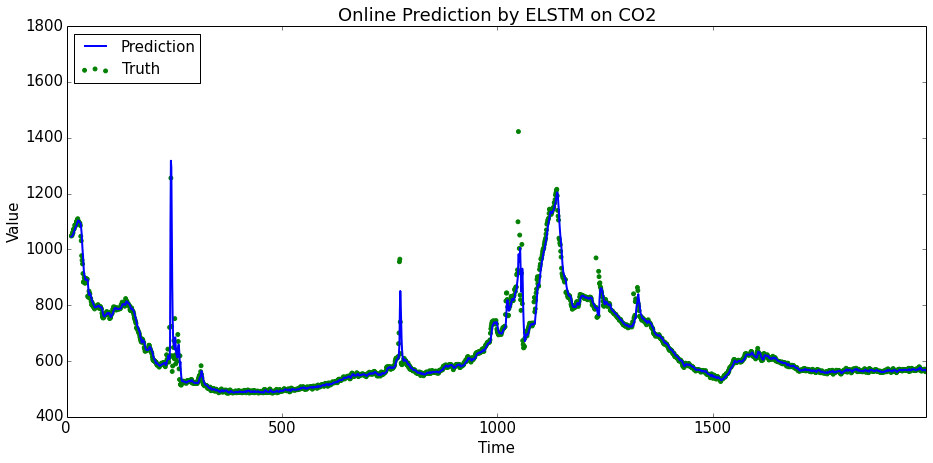

In [22]:
dtax, dtay = format_timeseries_rnn( ts_arr[dataset_idx] )

sgd = SGD(lr= 0.002, momentum=0.03, decay=0.0, nesterov=True) 
sc_t, sc_tst_x, sc_tst_y, sc_tst_pred_y= scc_train_rnn(dtax, dtay, sgd, loss_func,\
                                                 ts_flag_arr[dataset_idx], 0.0001)

tmpmse=test_result_plot(sc_t, sc_tst_x, sc_tst_y, sc_tst_pred_y, "ELSTM" , yrange_arr[dataset_idx],\
                 dataset_names[dataset_idx],True,ts_cpt_arr[dataset_idx], winsize)
nmse_arr[2]=tmpmse

In [18]:
# record all the results
import pickle

pickle.dump(rl_tst_x, open("../res/rl_yr_x"+dataset_names[dataset_idx], "wb") )
pickle.dump(rl_tst_y, open("../res/rl_yr_y"+dataset_names[dataset_idx], "wb") )
pickle.dump(rl_tst_pred_y, open("../res/rl_yr_py"+dataset_names[dataset_idx], "wb") )

pickle.dump(sk_tst_x, open("../res/sk_yr_x"+dataset_names[dataset_idx], "wb") )
pickle.dump(sk_tst_y, open("../res/sk_yr_y"+dataset_names[dataset_idx], "wb") )
pickle.dump(sk_tst_pred_y, open("../res/sk_yr_py"+dataset_names[dataset_idx], "wb") )

pickle.dump(sc_tst_x, open("../res/sc_yr_x"+dataset_names[dataset_idx], "wb") )
pickle.dump(sc_tst_y, open("../res/sc_yr_y"+dataset_names[dataset_idx], "wb") )
pickle.dump(sc_tst_pred_y, open("../res/sc_yr_yr"+dataset_names[dataset_idx], "wb") )

print nmse_arr
pickle.dump(nmse_arr, open("../res/nmse_"+dataset_names[dataset_idx], "wb") )


[16.48517334597555, 14.963793267157962, 14.956024226173659]


In [25]:
#  load the previous results
for i in range( len(nmse_arr) ):
    print pickle.load( open("../res/nmse_"+dataset_names[i], "rd") )


[10.010310864922344, 9.4451792623678958, 10.47048721583109]
[667.66033628606499, 629.80904867566255, 598.89213830916287]
[7617.4112436976411, 15345.123430446649, 7962.5024807271529]


In [ ]:
Syn: 0.0006(0.001),0.0005, 0.0001 
YSyn: 0.005 0.001 0.001, 0.006 0.003 0.001
YReal: 0.005, 0.001, 0.001

acceler: 0.0052 0.005 0.003
